In [1]:
from functools import partial
from json import dumps
import os
import pickle
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datasets
from datasets.utils.logging import disable_progress_bar
from sklearn.feature_extraction.text import TfidfVectorizer
import transformers
import torch
import tqdm
from tqdm.contrib.concurrent import process_map

from postprocess import PostProcessorDP
import utils

split_ratio_for_test = 0.3
split_ratio_for_postprocessing = 0.5  # after test split

# The seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 43)

# This seed controls the randomness during pre-training (fixed).
seed_for_pretraining = 33

max_workers = 10
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

model_dir = "models/biasbios_cross_entropy_50"
data_dir = "data/biasbios"

# BERT config
model_name = "bert-base-uncased"
n_epochs = 3
batch_size = 32
gradient_accumulation_steps = 1
lr = 2e-5
warmup_ratio = 0.1
weight_decay = 0.01
max_grad_norm = 1.0

disable_progress_bar()
transformers.set_seed(seed_for_pretraining)

## Download and load BiasBios dataset

In [2]:
label_names = [
    "accountant", "architect", "attorney", "chiropractor", "comedian",
    "composer", "dentist", "dietitian", "dj", "filmmaker", "interior_designer",
    "journalist", "model", "nurse", "painter", "paralegal", "pastor",
    "personal_trainer", "photographer", "physician", "poet", "professor",
    "psychologist", "rapper", "software_engineer", "surgeon", "teacher",
    "yoga_teacher"
]
n_classes = len(label_names)

group_names = ["female", "male"]
n_groups = len(group_names)

features = datasets.Features({
    "bio": datasets.Value("string"),
    "title": datasets.ClassLabel(names=label_names),
    "gender": datasets.ClassLabel(names=group_names),
})

if not os.path.exists(f"{data_dir}/deduplicated"):

  train_path = f"{data_dir}/train.pickle"
  test_path = f"{data_dir}/test.pickle"
  dev_path = f"{data_dir}/dev.pickle"
  if any([not os.path.exists(p) for p in [train_path, test_path, dev_path]]):
    os.makedirs(data_dir, exist_ok=True)
    urllib.request.urlretrieve(
        "https://storage.googleapis.com/ai2i/nullspace/biasbios/train.pickle",
        train_path)
    urllib.request.urlretrieve(
        "https://storage.googleapis.com/ai2i/nullspace/biasbios/test.pickle",
        test_path)
    urllib.request.urlretrieve(
        "https://storage.googleapis.com/ai2i/nullspace/biasbios/dev.pickle",
        dev_path)

  rows = {k: [] for k in features}
  for split, path in zip(["train", "test", "dev"],
                         [train_path, test_path, dev_path]):
    with open(path, "rb") as pickle_file:
      for row in pickle.load(pickle_file):
        rows["gender"].append("female" if row["g"] == "f" else "male")
        rows["title"].append(row["p"])
        rows["bio"].append(rows["gender"][-1] + ". " +
                           row["hard_text_untokenized"])

  # We remove duplicate bios from the dataset, and re-split it.
  raw_dataset = datasets.Dataset.from_dict(rows, features=features)

  vectorizer = TfidfVectorizer()
  v = vectorizer.fit_transform(raw_dataset["bio"])

  def remove_duplicates(i):
    if (v[i + 1:] @ v[i].T).max() > 0.98:
      return i

  rows_to_remove = process_map(
      remove_duplicates,
      range(v.shape[0] - 1),
      chunksize=100,
      max_workers=32,
  )  # takes about an hour on 32 cores
  rows_to_remove = set(rows_to_remove) - set([None])
  print(rows_to_remove)

  raw_dataset = raw_dataset.select(
      [i for i in range(len(raw_dataset)) if i not in set(rows_to_remove)])
  raw_dataset.save_to_disk("data/biasbios/deduplicated")

else:
  raw_dataset = datasets.load_from_disk("data/biasbios/deduplicated")

print(dumps(raw_dataset[seed_for_pretraining], indent=2))

{237568, 229377, 122882, 241669, 188427, 90125, 208916, 94231, 208921, 262174, 331806, 28705, 57381, 90158, 131122, 122954, 32843, 61515, 4173, 155722, 200780, 41041, 12370, 262229, 184413, 53347, 168035, 114792, 127086, 16496, 86131, 143479, 258171, 127110, 114826, 4237, 65678, 282766, 336014, 65686, 86175, 336036, 16550, 41127, 16557, 28851, 204981, 53430, 20664, 45245, 94397, 147648, 295106, 106696, 4298, 368847, 16593, 49363, 331987, 176342, 209113, 221409, 356577, 49380, 147686, 102632, 299240, 98545, 94457, 151805, 221437, 61695, 127231, 360703, 114951, 123144, 303368, 28939, 57612, 160014, 74000, 90387, 139540, 20760, 209176, 131363, 299303, 151848, 160043, 20780, 86324, 172342, 143672, 364856, 16698, 98619, 57661, 78142, 229694, 184643, 254275, 160069, 53577, 82259, 102741, 90463, 106852, 135532, 57709, 74094, 37231, 143726, 377, 70015, 229763, 266627, 172423, 86408, 205193, 160138, 205196, 233869, 70034, 115091, 404, 217493, 389523, 164249, 188834, 420, 102823, 348589, 287157,

In [3]:
# Compute and print dataset statistics

df = pd.DataFrame(np.stack([
    np.array(group_names)[raw_dataset["gender"]],
    np.array(label_names)[raw_dataset["title"]]
],
                           axis=1),
                  columns=["Group", "Target"])
df_grouped = df.groupby(["Target", "Group"]).size().unstack()
counts = df_grouped.sum(axis=0)

print("Dataset statistics:")
display(df_grouped / counts)
display(pd.DataFrame(counts, columns=["Count"]).T)

print("Perfect results if dataset equals population:")
display(
    pd.DataFrame([{
        "alpha":
            np.inf,
        "error_rate":
            0.0,
        "delta_dp":
            utils.delta_dp(raw_dataset["title"], raw_dataset["gender"]),
        "delta_dp_rms":
            utils.delta_dp(
                raw_dataset["title"],
                raw_dataset["gender"],
                ord=2,
            ) / np.sqrt(n_classes)
    }, {
        "alpha":
            0.0,
        "error_rate":
            PostProcessorDP().fit(
                scores=np.concatenate(
                    [np.eye(n_classes) for _ in range(n_groups)], axis=0),
                groups=np.repeat(np.arange(n_groups), n_classes),
                r=np.nan_to_num(
                    (df_grouped.to_numpy() / counts.to_numpy())).T.flatten(),
            ).score_,
        "delta_dp":
            0.0,
        "delta_dp_rms":
            0.0
    }]).groupby('alpha').agg('mean').sort_index(ascending=False))

Dataset statistics:


Group,female,male
Target,,
accountant,0.011413,0.016915
architect,0.013191,0.036488
attorney,0.068388,0.095184
chiropractor,0.003766,0.008773
comedian,0.003248,0.010449
composer,0.005048,0.022179
dentist,0.028177,0.043832
dietitian,0.020227,0.001372
dj,0.001162,0.006043


Group,female,male
Count,181640,210645


Perfect results if dataset equals population:


,error_rate,delta_dp,delta_dp_rms
alpha,,,
inf,0.000000,0.08653,0.02375
0.0,0.115632,0.00000,0.00000


### Tokenize BiasBios dataset

In [4]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
  tokenized_examples = tokenizer(
      examples["bio"],
      padding=False,
      max_length=tokenizer.model_max_length,
      truncation=True,
  )
  tokenized_examples["labels"] = examples["title"]
  tokenized_examples["group_labels"] = examples["gender"]
  return tokenized_examples


tokenized_dataset = raw_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=raw_dataset.column_names,
    desc="Running tokenizer on dataset",
)

In [5]:
# Prepare the dataset for pre-training
split_dataset = tokenized_dataset.train_test_split(
    test_size=(1 - split_ratio_for_test) * (1 - split_ratio_for_postprocessing),
    seed=seed_for_pretraining)
dataset_ = split_dataset["train"]
train_dataset_pre = split_dataset["test"]

data_collator = transformers.DataCollatorWithPadding(tokenizer)
train_dataloader_pre = torch.utils.data.DataLoader(
    train_dataset_pre,
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)
dataloader_ = torch.utils.data.DataLoader(
    dataset_,
    collate_fn=data_collator,
    batch_size=batch_size,
)

n_samples = len(raw_dataset)
n_pre = len(train_dataset_pre)
n_test = int(n_samples * split_ratio_for_test)
n_post = n_samples - n_pre - n_test

## Load/train BERT model

In [6]:
model = None
model_loaded_from_disk = False
if os.path.exists(model_dir):
  model = transformers.AutoModelForSequenceClassification.from_pretrained(
      model_dir).to(device)
  model_loaded_from_disk = True
else:
  model = transformers.AutoModelForSequenceClassification.from_pretrained(
      model_name, num_labels=n_classes).to(device)

model_input_args = list(model.forward.__code__.co_varnames)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [7]:
if not model_loaded_from_disk:
  no_decay = ["bias", "LayerNorm.weight"]
  optimizer_grouped_parameters = [
      {
          "params": [
              p for n, p in model.named_parameters()
              if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": weight_decay,
      },
      {
          "params": [
              p for n, p in model.named_parameters()
              if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0
      },
  ]
  optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr)
  lr_scheduler = transformers.get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=(warmup_ratio * n_epochs * len(train_dataloader_pre)),
      num_training_steps=n_epochs * len(train_dataloader_pre))

  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(n_epochs):

    model.train()
    for step, batch in enumerate(
        tqdm.tqdm(train_dataloader_pre, desc=f"epoch {epoch}, train")):
      batch = {
          k: v.to(device) for k, v in batch.items() if k in model_input_args
      }
      outputs = model(**batch)
      loss = loss_fn(outputs.logits,
                     batch["labels"]) / gradient_accumulation_steps
      loss.backward()
      if (step + 1) % gradient_accumulation_steps == 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    model.eval()
    labels = []
    predictions = []
    for batch in tqdm.tqdm(dataloader_, desc=f"epoch {epoch}, eval"):
      batch = {
          k: v.to(device) for k, v in batch.items() if k in model_input_args
      }
      with torch.no_grad():
        outputs = model(**batch)
        probas = outputs.logits
        predictions.extend(torch.argmax(probas, dim=-1).cpu().numpy())
        labels.extend(batch["labels"].cpu().numpy())
    print(
        f"epoch {epoch}, error rate: {np.mean(np.array(predictions) != np.array(labels))}"
    )

  model.save_pretrained(model_dir)

epoch 0, eval: 100%|████████████████████████| 7969/7969 [09:53<00:00, 13.42it/s]


epoch 0, error rate: 0.14918524619095241


epoch 1, eval: 100%|████████████████████████| 7969/7969 [09:53<00:00, 13.43it/s]


epoch 1, error rate: 0.13969841363217445


epoch 2, eval: 100%|████████████████████████| 7969/7969 [09:53<00:00, 13.42it/s]


epoch 2, error rate: 0.1396944918328529


In [8]:
if os.path.exists(f"{model_dir}/probas.pkl"):
  with open(f"{model_dir}/probas.pkl", "rb") as f:
    probas_, labels_, groups_ = pickle.load(f)

else:

  def predict_fn(dataloader):
    model.eval()
    probas = []
    with torch.no_grad():
      for batch in tqdm.tqdm(dataloader, desc="Inference"):
        batch = {
            k: v.to(device) for k, v in batch.items() if k in model_input_args
        }
        outputs = model(**batch)
        probas.append(
            torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy())
    return np.concatenate(probas, axis=0)

  transformers.set_seed(seed_for_pretraining)
  probas_ = predict_fn(dataloader_)
  labels_ = np.array(dataset_["labels"])
  groups_ = np.array(dataset_["group_labels"])

  with open(f"{model_dir}/probas.pkl", "wb") as f:
    pickle.dump((probas_, labels_, groups_), f)

  # del model
  # torch.cuda.empty_cache()

Inference: 100%|████████████████████████████| 7969/7969 [09:53<00:00, 13.43it/s]


## DP post-processing (demographic parity)

  0%|          | 0/200 [00:00<?, ?it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/home/rxian/fair-classification/postprocess.py:144: UserWarning: Point-finding QP failed, falling back to LP.
  warnings.warn("Point-finding QP failed, falling back to LP.")


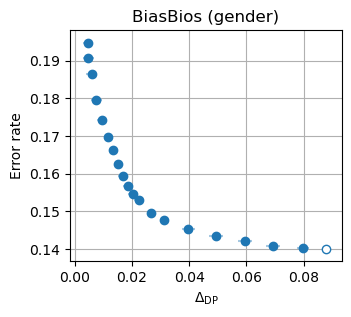

error_rate            delta_dp           delta_dp_rms          
             mean       std      mean       std         mean       std
alpha                                                                 
inf      0.140116  0.000561  0.087695  0.001227     0.023962  0.000218
0.0800   0.140320  0.000619  0.079705  0.002132     0.023063  0.000303
0.0700   0.140902  0.000676  0.069421  0.002454     0.021889  0.000324
0.0600   0.142078  0.000690  0.059554  0.002446     0.020871  0.000307
0.0500   0.143484  0.000680  0.049346  0.002538     0.019940  0.000280
0.0400   0.145290  0.000675  0.039710  0.002326     0.019138  0.000267
0.0300   0.147607  0.000706  0.031241  0.001377     0.017418  0.000321
0.0250   0.149683  0.000705  0.026770  0.001333     0.015786  0.000300
0.0200   0.152922  0.000755  0.022341  0.001498     0.013750  0.000252
0.0180   0.154637  0.000820  0.020442  0.001690     0.012826  0.000230
0.0160   0.156778  0.000648  0.018596  0.001795     0.011842  0.000196
0.0140   0.159453  0.000705  0.016867  0.001718     0.010634  0.000242
0.0120   0.162587  0.000634  0.015134  0.001509     0.009332  0.000228
0.0100   0.166186  0.000849  0.013365  0.001426     0.008059  0.000250
0.0080   0.169879  0.000977  0.011622  0.001499     0.006811  0.000268
0.0060   0.174299  0.000841  0.009636  0.001829     0.005491  0.000268
0.0040   0.179607  0.000970  0.007616  0.001873     0.003983  0.000287
0.0020   0.186553  0.000842  0.005914  0.001860     0.002473  0.000293
0.0010   0.190761  0.000825  0.004769  0.001896     0.001776  0.000407
0.0001   0.194579  0.000693  0.004620  0.001831     0.001549  0.000417

In [9]:
alphas = [
    np.inf, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.025, 0.02, 0.018, 0.016,
    0.014, 0.012, 0.01, 0.008, 0.006, 0.004, 0.002, 0.001, 0.0001
]

return_vals = process_map(
    partial(
        utils.postprocess,
        postprocessor_factory=PostProcessorDP,
        evaluate_fn=partial(utils.evaluate,
                            n_groups=n_groups,
                            n_classes=n_classes,
                            metrics=['delta_dp', 'delta_dp_rms']),
        probas=probas_,
        labels=labels_,
        groups=groups_,
        n_post=n_post,
        n_test=n_test,
    ),
    [(alpha, seed) for alpha in alphas for seed in seeds],
    max_workers=max_workers,
)
results = [{
    'alpha': alpha,
    **result
} for alpha, _, result, _ in return_vals if result is not None]

(fig, ax), df = utils.plot_results(results, 'delta_dp')
ax.set_xlabel("$\\Delta_{\\mathrm{DP}}$")
ax.set_title("BiasBios (gender)")
plt.show()
display(df)